In [40]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os, torch
import torch.nn as nn
import torch.optim as optim
import itertools

from tqdm import tqdm
from ista_unet import *
from ista_unet.models import ista_unet
from ista_unet.evaluate import *
from ista_unet.load_apples_dataset import get_dataloaders_ct
from dival.measure import PSNR, SSIM

from dival.util.plot import plot_images
import dival

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

noise_setting = 'scattering'
num_angles = 50

loaders_bs1 = get_dataloaders_ct(batch_size=1, distributed_bool = False, num_workers = 0, 
                                 IMPL = 'astra_cuda', 
                                 include_validation = True,
                                 noise_setting = noise_setting,
                                 num_angles = num_angles)

In [41]:
guid = None
if noise_setting == 'noisefree':
    if num_angles == 50:
        # 512 256 128 64 32 seems better than 512 256 128 64 32 16, at least when judging from the first 3 epochs
        guid = '0cd136af-66ff-4903-9c7e-03bf07255039'  # pinky, 5 epochs: 37.96dB
        # guid = 'ad07b395-156d-4522-9b75-3a90a2bc1700'  # magneto, init lambda 1e-4: nnz ['0.00', '0.00', '0.00', '0.00', '0.07'], suboptimal
        # guid = '439d0617-097e-4de3-8620-633bd473aca3'  # magneto, widths [64, 32], suboptimal
        # guid = '60d5d299-84a8-4e68-9b80-d6c413221ff2'  # scenenet, widths [512, 256, 128, 64, 32, 16]: ~36.7dB after 5 epochs
        # guid = 'ad7223d5-c848-4635-b174-cfc58afdd7b6'  # pinky, widths [512, 256, 128, 64, 32, 16], init lambda 1e-6: ~36.6dB after 3 epochs
    elif num_angles == 5:
        guid = '19ffea0a-c387-48b8-a445-08ff77c3b22d'  # magneto: ~27.3dB, nnz ['0.33', '0.19', '0.08', '0.02', '0.00']
        # guid = '9bda0b1c-a381-4d8e-b69e-194f5a7814b3'  # scenenet, widths [512, 256, 128, 64, 32, 16]: ~27.3dB, nnz ['0.34', '0.29', '0.25', '0.10', '0.09', '0.00']
elif noise_setting == 'gaussian_noise':
    if num_angles == 50:
        guid = '52e07ea6-fc7f-417e-a90d-52caeb49ee1f'  # pinky, old gaussian_noise 50, widths [512, 256, 128, 64, 32], init lambda 1e-3, 15 epochs: 36.19dB, nnz ['0.00', '0.02', '0.01', '0.08', '0.00']
        # guid = '3c3225e6-7c5f-4c01-8197-dc742abd90a4'  # pinky, new short gaussian_noise 50, widths [512, 256, 128, 64, 32], 3 epochs: 35.00dB, nnz ['0.12', '0.04', '0.04', '0.04', '0.00']
        # guid = '3c456117-c377-4065-838e-93294aa04492'  # pinky, new short gaussian_noise 50: 35.83dB, nnz ['0.24', '0.20', '0.14', '0.07', '0.16', '0.01']
    elif num_angles == 5:
        guid = '9cfcb7d2-103c-4a83-a5f7-69c17ccc8d5e'  # magneto g3
        # guid = 'bbd043fa-9e23-428a-8ab1-7257cb1b7710'  # pinky g1
elif noise_setting == 'scattering':
    if num_angles == 50:
        # 512 256 128 64 32 16 seems better than 512 256 128 64 32
        # guid = '1756c7da-13f8-4e59-915d-6062e388413f'  # pinky, 20 epochs, 33.96dB, nnz ['0.58', '0.65', '0.56', '0.67', '0.57', '0.62']
        guid = '65820ef7-a034-4ebc-968b-13f31c41f85e'  # magneto g1, --NUM_EPOCH 80
    elif num_angles == 10:
        # guid = '4d58f140-a87b-439f-ac8e-c91fa23e7b48'  # magneto g7, 20 epochs, 30.86dB, nnz ['0.82', '0.82', '0.82', '0.63', '0.67', '0.54']
        # guid = 'bab6f8c0-6174-45e0-8090-b0a2143575c6'  # magneto g1, 20 epochs, 31.14dB, nnz ['0.45', '0.44', '0.55', '0.52', '0.53', '0.62']
        guid = 'b465d2fe-0ae7-426f-b134-0e12ca80e8b9'  # magneto g2, --NUM_EPOCH 40
    elif num_angles == 5:
        guid = 'f6b01af6-3053-467b-90c5-ac6498415fd2'  # pinky, 20 epochs: 26.30dB, nnz ['0.58', '0.55', '0.58', '0.52', '0.51', '0.63']
    elif num_angles == 2:
        # guid = '32aa4d36-799c-4ef7-9fcf-0a2d00945839'  # pinky, 20 epochs: 19.25dB, nnz ['0.54', '0.43', '0.49', '0.49', '0.53', '0.69']
        guid = '6f36b94f-5b74-4b6f-bc80-acb6c4769553'  # pinky, 15 epochs: 19.31dB, nnz ['0.29', '0.25', '0.31', '0.42', '0.51', '0.53']

model, config_dict = load_ista_unet_model(guid = guid, 
                             dataset = 'fbpistaunet_{}_{:02d}'.format(noise_setting, num_angles), 
                             return_config_dict = True)

model.to(device);
print(config_dict)

{'kernel_size': 3, 'hidden_layer_width_list': [512, 256, 128, 64, 32, 16], 'n_classes': 1, 'ista_num_steps': 5, 'lasso_lambda_scalar': 0.0001, 'uncouple_adjoint_bool': True, 'relu_out_bool': True, 'batch_size': 1, 'num_workers': 0, 'distributed_bool': True, 'noise_setting': 'scattering', 'num_angles': 50, 'num_epochs': 80, 'criterion': MSELoss(), 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0001
    lr: 7.851243541221771e-05
    weight_decay: 0
), 'scheduler': <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7f7afceef0d0>, 'device': 0, 'guid': '65820ef7-a034-4ebc-968b-13f31c41f85e', 'saved_path': '/localdata/jleuschn/ISTA-U-Net_results/fbpistaunet_scattering_50/65820ef7-a034-4ebc-968b-13f31c41f85e'}


In [37]:
config_dict['scheduler'].state_dict()

{'T_max': 20,
 'eta_min': 1e-05,
 'base_lrs': [0.0001],
 'last_epoch': 17,
 '_step_count': 18,
 'verbose': False,
 '_get_lr_called_within_step': False,
 '_last_lr': [1.490470641152345e-05]}

In [24]:
with torch.no_grad():
    noisy_batch, _ = next(iter(loaders_bs1['validation']))
    codes = model.sparse_coder(noisy_batch.to(device))
for code in codes:
    print(code.shape)
print(['{:.2f}'.format(np.count_nonzero(code.cpu() ) / len(code.flatten())) for code in codes])

torch.Size([1, 512, 30, 30])
torch.Size([1, 256, 60, 60])
torch.Size([1, 128, 121, 121])
torch.Size([1, 64, 243, 243])
torch.Size([1, 32, 486, 486])
torch.Size([1, 16, 972, 972])
['0.29', '0.25', '0.31', '0.42', '0.51', '0.53']


## calculate psnr and ssim

### psnr: ista unet

In [25]:
def evaluate_model_psnr(model, loader, phase):
    metric_result_list = []
    running_metric_result = 0
    running_size = 0 
    model.to(device)
    model.eval()
    num_images = 100

    with torch.no_grad():
        with tqdm(itertools.islice(loader[phase], num_images), total=num_images) as pbar:
            for obs, gt in pbar:
                if noise_setting == 'scattering':
                    obs = obs/400
                reco = model(obs.to(device)).cpu()
                reco = reco.clamp(0,1)
                current_metric_result = PSNR(reco, gt) 
                metric_result_list.append(current_metric_result)
                running_metric_result += current_metric_result
                running_size += 1
                pbar.set_postfix({'phase': phase,
                                  'psnr': '{:.2f}'.format(running_metric_result/running_size)})

    print('mean psnr: {:f}'.format(np.mean(metric_result_list)))
    return metric_result_list

In [26]:
metric_result_list = evaluate_model_psnr(model, loaders_bs1, 'validation')

100%|██████████| 100/100 [00:28<00:00,  3.49it/s, phase=validation, psnr=19.31]

mean psnr: 19.306584


In [6]:
metric_result_list = evaluate_model_psnr(model, loaders_bs1, 'test')

100%|██████████| 3553/3553 [06:16<00:00,  9.43it/s, phase=test, psnr=35.9]

mean psnr: 35.909043


### ssim: ista unet

In [9]:
def evaluate_model_ssim(model, loader, phase):
    metric_result_list = []
    running_metric_result = 0
    running_size = 0 
    model.to(device)
    model.eval()

    with torch.no_grad():
        with tqdm(loader[phase]) as pbar:
            for obs, gt in pbar:
                
                reco = model(obs.to(device)).cpu()
                reco = reco.clamp(0,1)
                current_metric_result = SSIM(reco[0,0].detach().numpy(), gt[0,0].detach().numpy()) 
                metric_result_list.append(current_metric_result)
                running_metric_result += current_metric_result
                running_size += 1
                pbar.set_postfix({'phase': phase,
                                  'ssim': running_metric_result/running_size})

    print('mean ssim: {:f}'.format(np.mean(metric_result_list)))
    return metric_result_list

In [10]:
metric_result_list = evaluate_model_ssim(model, loaders_bs1, 'validation')

100%|██████████| 3522/3522 [06:33<00:00,  8.95it/s, phase=validation, ssim=0.882]

mean ssim: 0.882364


In [11]:
metric_result_list = evaluate_model_ssim(model, loaders_bs1, 'test')

100%|██████████| 3553/3553 [06:36<00:00,  8.97it/s, phase=test, ssim=0.845]

mean ssim: 0.844551


## Visualization

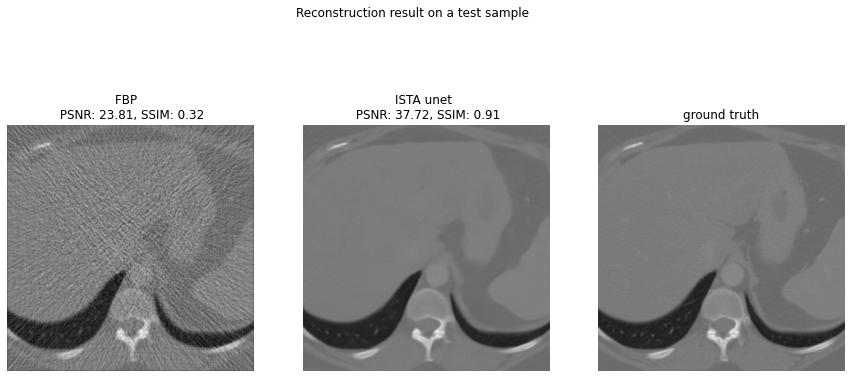

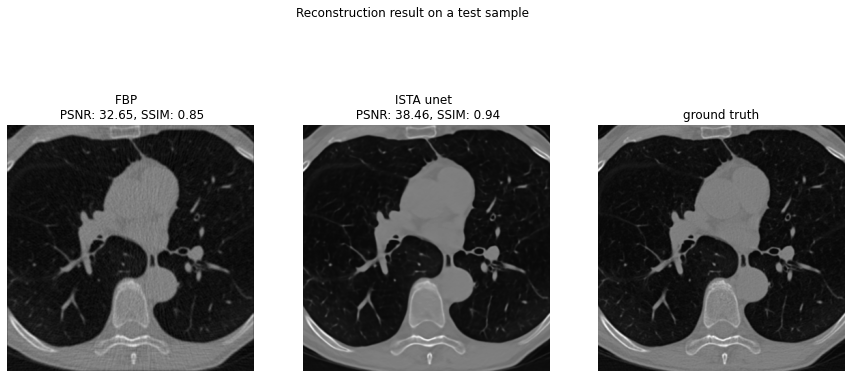

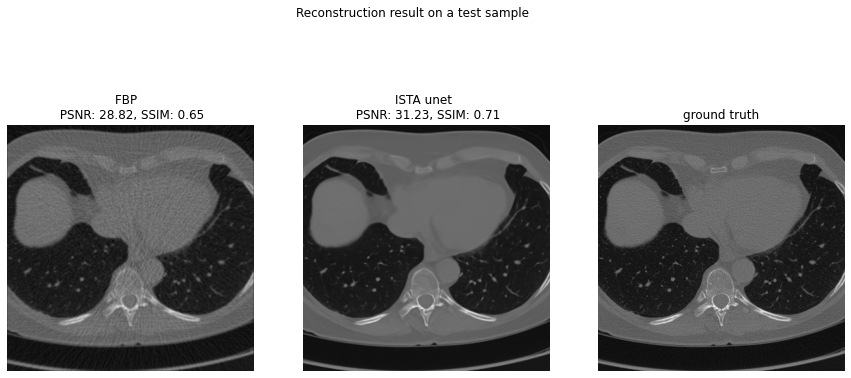

In [14]:
for sample_at in range(3):
    # sample_at = 1
    obs, gt = next(itertools.islice(loaders_bs1['test'], sample_at, None))

    recon = model(obs.to(device)).cpu().detach().numpy()
    # evaluate w/ psnr and ssim
    
    obs_psnr = PSNR(obs, gt)
    ista_unet_psnr = PSNR(recon, gt)

    obs_ssim = SSIM(obs[0,0].numpy(), gt[0,0].numpy())
    ista_unet_ssim = SSIM(recon[0,0], gt[0,0].numpy())

    _, ax = plot_images([obs.cpu()[0,0], recon[0,0], gt.cpu()[0,0]], fig_size=(15, 7), cbar = 'none')
    ax[0].set_title('FBP  \n PSNR: {:.2f}, SSIM: {:.2f}'.format(obs_psnr, obs_ssim) )
    ax[0].axis('off')
    ax[1].set_title('ISTA unet \n PSNR: {:.2f}, SSIM: {:.2f}'.format(ista_unet_psnr, ista_unet_ssim))
    ax[1].axis('off')
    ax[2].set_title('ground truth')
    ax[2].axis('off')

    ax[1].figure.suptitle('Reconstruction result on a test sample')